# CNN Implementation for the Simpsons Characters Recognition

In [8]:
# paste below in your terminal after activating your conda environment
# git clone https://github.com/Yichen-Wang-2003/M156_Group1_Final_project

In [9]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import os

In [10]:
print(os.getcwd())
torch.cuda.is_available()
import torch
print(torch.__version__)
print(torch.version.cuda)
import sys
print(sys.executable)


C:\Users\madis\Desktop\M156_Group1_Final_project-main
2.1.1+cu121
12.1
C:\Users\madis\anaconda3\envs\text2\python.exe


In [11]:
 #os.chdir('')

In [12]:
print(os.getcwd())

C:\Users\madis\Desktop\M156_Group1_Final_project-main


## 1. Data Processing and Dataloader

In [14]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

data = datasets.ImageFolder(root='./archive/simpsons_dataset', transform=transform)

dataloader = DataLoader(data, batch_size=64, shuffle=True, num_workers=2)

def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    
    return mean, std

mean, std = get_mean_std(dataloader)

print(f'mean: {mean}')
print(f'std: {std}')

mean: tensor([0.4624, 0.4076, 0.3524])
std: tensor([0.2445, 0.2216, 0.2535])


In [15]:
print(len(data.classes))

42


In [18]:
# data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(),
                         std=std.tolist())
])

data = datasets.ImageFolder(root='./archive/simpsons_dataset', transform=transform)

# split the dataset into training and validation
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

# create data loaders for training, validation, and testing
train = DataLoader(train_data, batch_size=64, shuffle=True)
val = DataLoader(val_data, batch_size=64, shuffle=False)
test = DataLoader(test_data, batch_size=64, shuffle=True)

In [19]:
print(len(data.classes))

42


In [20]:
print(f'found {len(train_data)} images belonging to {len(data.classes)} classes in the training set.')
print(f'found {len(val_data)} images belonging to {len(data.classes)} classes in the validation set.')
print(f'found {len(test_data)} images belonging to {len(data.classes)} classes in the validation set.')

found 16746 images belonging to 42 classes in the training set.
found 2093 images belonging to 42 classes in the validation set.
found 2094 images belonging to 42 classes in the validation set.


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import os
import time


In [22]:
torch.manual_seed(42)  # for reproducibility

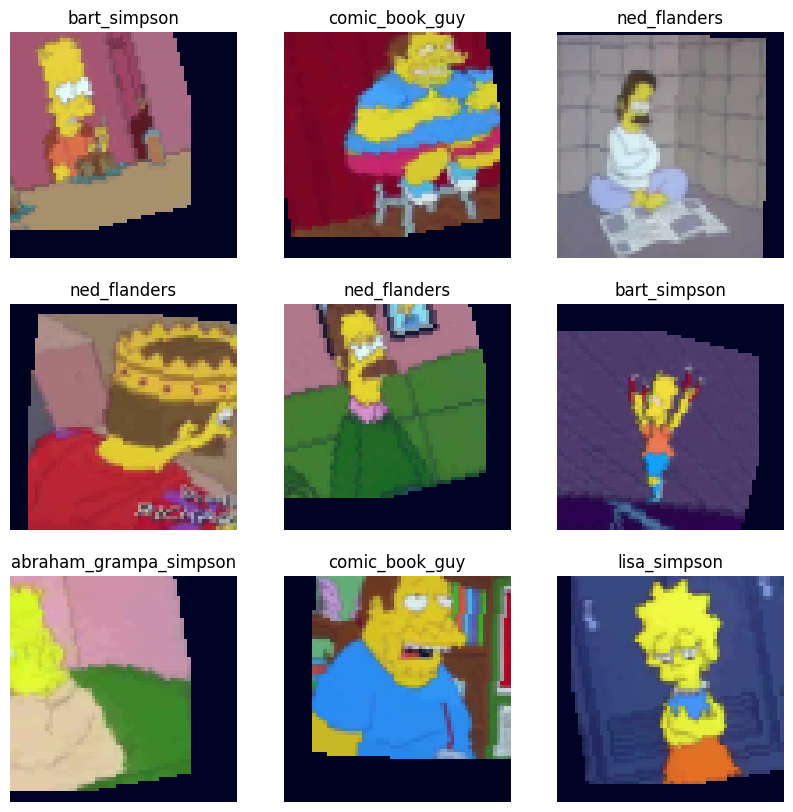

In [50]:
import matplotlib.pyplot as plt

# Assuming 'train' is your DataLoader for the training set
dataiter = iter(train)
images, labels = next(dataiter)  # Get a batch of images and labels

class_names = data.classes  # Assuming this gives you the list of class names

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i].numpy().transpose((1, 2, 0))  # Convert from torch tensor to numpy and fix the channel order
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [25]:
dataloaders = {
    'train': train,
    'val': val
}
dataset_sizes = {
    'train': len(train_data),
    'val': len(val_data)
}


## 2. Convolutional Neural Network and Resnet Block for Simpson Character Recognition

In [26]:
class ResnetBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super(ResnetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.downsample = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )

    def forward(self, x):

        i = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += i
        out = self.relu1(out)
        return out

In [27]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  
        self.bn1 = nn.BatchNorm2d(32)  # Added BatchNorm
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Conv
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Added BatchNorm
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Conv
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Two resnet layers
        self.ResnetBlock1 = ResnetBlock(128, 128)
        self.ResnetBlock2 = ResnetBlock(128, 128)

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(8192, 1024) 
        self.relu4 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(512, num_figure)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.maxpool1(x)
    
        x = self.relu2(self.conv2(x))
        x = self.maxpool2(x)
        
        x = self.relu3(self.conv3(x))
        x = self.maxpool3(x)

        x = self.ResnetBlock1(x)
        x = self.ResnetBlock2(x)
        
        x = self.dropout(x)

        x = x.view(x.size(0), -1)

        x = self.relu4(self.fc1(x))
        x = self.relu5(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

## 3. Training phase and validation

In [28]:
# number of Simpson characters
num_figure = 42
epoch_limit = 100
model = ConvNet()
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = model.to(device)

# Set criterion to be CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Using L2 regularization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Setup scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Setup early stopping
stop_training = False
count_early_stop = 0
best_loss = None


# Set some thing to store and keep track of the best model
val_loss = []
val_acc = []
train_loss = []
train_acc = []
epoch_update = 0

start_time = time.time()
# keep training until early stop met or reach epoch limit
while not stop_training and epoch_update < epoch_limit:
  
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
    else:
      model.eval()

    running_loss = 0.0
    running_corrects = 0
    # iterate over data
    for inputs, labels in dataloaders[phase]:
      inputs = inputs.to(device)
      labels = labels.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      with torch.set_grad_enabled(phase == 'train'):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        if phase == 'train':
          loss.backward()
          optimizer.step()

      # update loss
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    if(phase == 'train'):
      train_loss.append(epoch_loss)
      train_acc.append(epoch_acc)
    else:
      val_loss.append(epoch_loss)
      val_acc.append(epoch_acc)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    # check early stop conditions for every epoch
    if phase == 'val':
      if best_loss == None or epoch_loss < best_loss:
        best_loss = epoch_loss
        count_early_stop = 0
        torch.save(model.state_dict(), 'best_model.pt')
      else:
        count_early_stop += 1
        if count_early_stop > 3:  # stop if validation loss does not improve for 3 epochs
          stop_training = True
      epoch_update += 1
      
  scheduler.step()

end_time= time.time()
elapsed_time = end_time - start_time
print(f"The code ran for {elapsed_time} seconds.")

cuda
train Loss: 2.4160 Acc: 0.3294
val Loss: 2.3972 Acc: 0.3502
train Loss: 1.5745 Acc: 0.5536
val Loss: 1.5162 Acc: 0.5815
train Loss: 1.2246 Acc: 0.6575
val Loss: 1.3993 Acc: 0.6269
train Loss: 1.0397 Acc: 0.7064
val Loss: 1.0254 Acc: 0.7081
train Loss: 0.8986 Acc: 0.7460
val Loss: 0.8903 Acc: 0.7453
train Loss: 0.8101 Acc: 0.7731
val Loss: 0.9503 Acc: 0.7348
train Loss: 0.7296 Acc: 0.7904
val Loss: 0.8850 Acc: 0.7501
train Loss: 0.5840 Acc: 0.8329
val Loss: 0.6554 Acc: 0.8127
train Loss: 0.5554 Acc: 0.8443
val Loss: 0.6303 Acc: 0.8261
train Loss: 0.5265 Acc: 0.8513
val Loss: 0.6398 Acc: 0.8204
train Loss: 0.5115 Acc: 0.8576
val Loss: 0.6293 Acc: 0.8333
train Loss: 0.5131 Acc: 0.8520
val Loss: 0.6076 Acc: 0.8328
train Loss: 0.5074 Acc: 0.8573
val Loss: 0.6320 Acc: 0.8266
train Loss: 0.4955 Acc: 0.8625
val Loss: 0.5961 Acc: 0.8342
train Loss: 0.4753 Acc: 0.8632
val Loss: 0.5927 Acc: 0.8328
train Loss: 0.4721 Acc: 0.8646
val Loss: 0.5740 Acc: 0.8404
train Loss: 0.4688 Acc: 0.8666
val 

In [29]:
print(epoch_update)

20


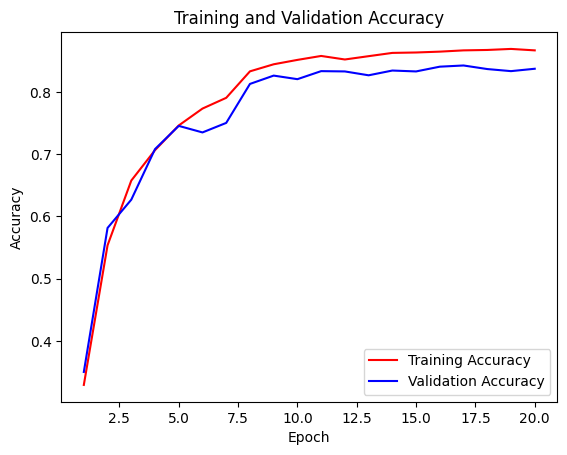

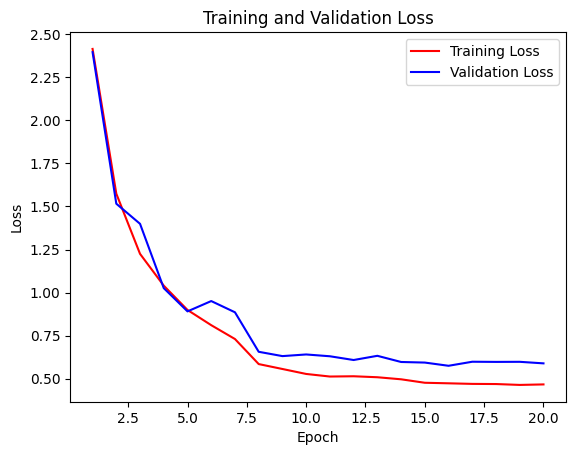

In [35]:
# # Visualize the validaton accuracy and training accuracy

# Convert lists of tensors to lists of scalars
train_acc_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in train_acc]
val_acc_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in val_acc]
train_loss_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in train_loss]
val_loss_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in val_loss]

# Convert lists of tensors to lists of scalars
train_acc_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in train_acc]
val_acc_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in val_acc]
train_loss_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in train_loss]
val_loss_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in val_loss]

# Now you can safely plot
plt.plot(epochs, train_acc_cpu, label='Training Accuracy', color='red')
plt.plot(epochs, val_acc_cpu, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, train_loss_cpu, label='Training Loss', color='red')
plt.plot(epochs, val_loss_cpu, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# epochs = list(range(1, epoch_update+1))
# plt.plot(epochs, train_acc.cpu(), label='Training Accuracy', color='red')
# plt.plot(epochs, val_acc.cpu(), label='Validation Accuracy', color='blue')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()
# plt.show()

# # Draw plot for training and validation loss
# plt.plot(epochs, train_loss.cpu(), label='Training Loss', color='red')
# plt.plot(epochs, val_loss.cpu(), label='Validation Loss', color='blue')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()


## 4. Test set evaluation

In [36]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0

# Prestored for visualization
images_num = 10
s_images = []
s_probs = []
s_preds = []
s_truth = []

with torch.no_grad():  # Do not calculate gradient
    for inputs, labels in test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()  # Sum up batch loss
        probs = torch.nn.functional.softmax(outputs, dim=1)  # Get probabilities from the softmax layer
        pred = outputs.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()

        # Select some images to visualize
        if len(s_images) < images_num:
            s_images.extend(inputs.cpu().data[:images_num-len(s_images)])
            s_probs.extend(probs.cpu().data[:images_num-len(s_probs)])
            s_preds.extend(pred.view(-1).cpu().data[:images_num-len(s_preds)])
            s_truth.extend(labels.cpu().data[:images_num-len(s_truth)])

test_loss /= len(test.dataset)
test_accuracy = 100. * correct / len(test.dataset)
print(f'Testset result: Average loss: {test_loss:.5f}, Accuracy: {correct}/{len(test.dataset)} ({test_accuracy:.2f}%)')


Testset result: Average loss: 0.00920, Accuracy: 1770/2094 (84.53%)


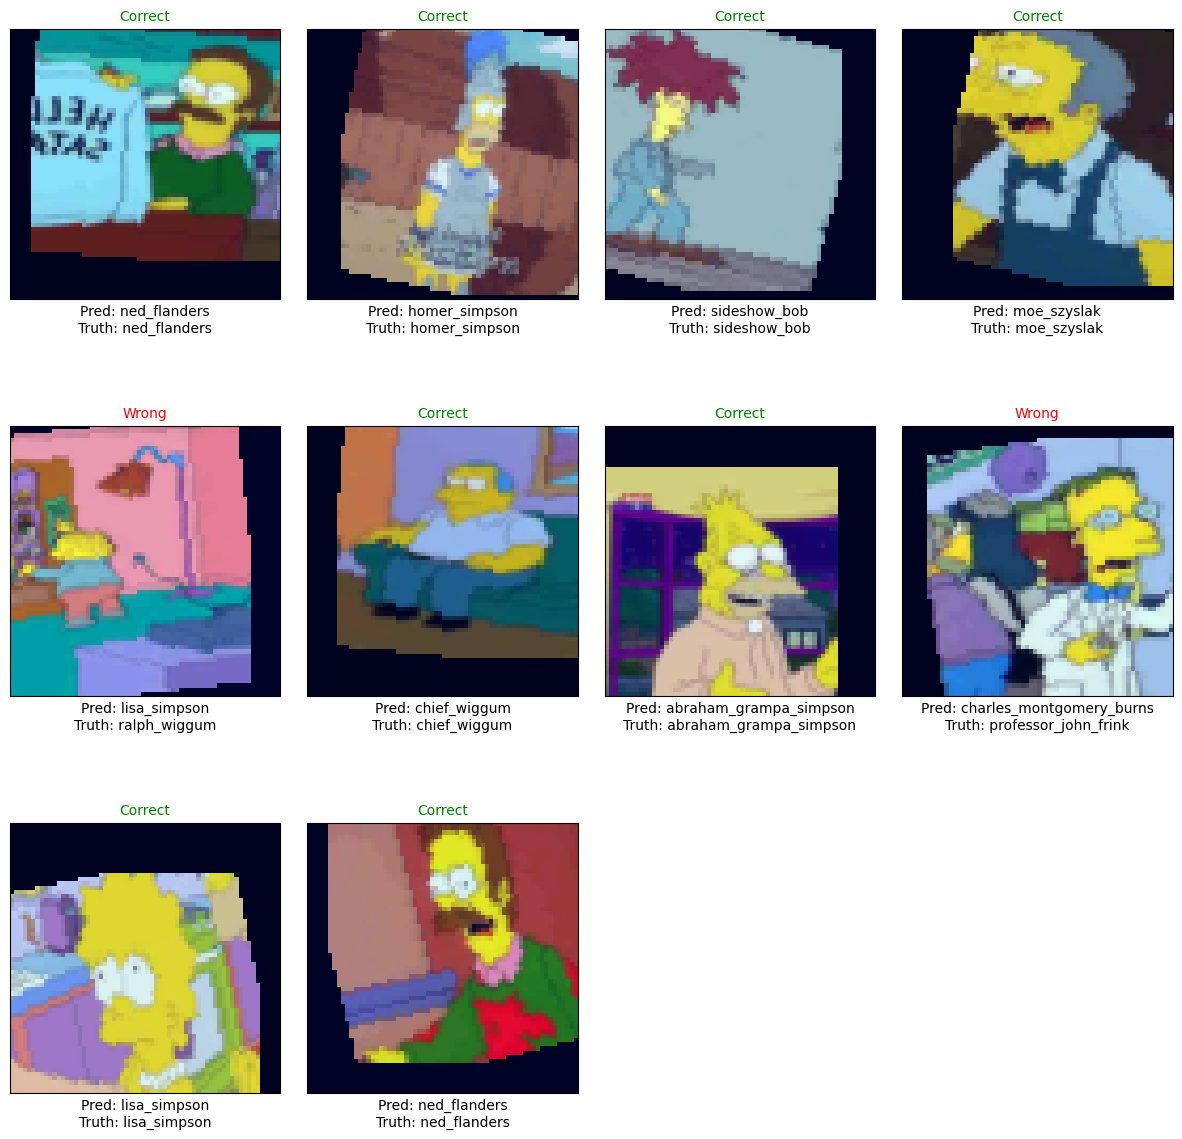

In [56]:
import matplotlib.pyplot as plt
import textwrap

def visualize_predictions(images, probabilities, predictions, truths, images_num=10):
    
    """
    Visualizes a set of images with their predicted and actual labels, with improvements for long names.
    
    Parameters:
    - images: A list of images.
    - probabilities: A list of softmax outputs.
    - predictions: A list of predictions.
    - truths: A list of ground truth labels.
    - images_num: The number of images to display. Default is 10.
    """

    class_names = data.classes  # Assuming 'data.classes' exists and is a list of class names
    images_to_show = min(len(images), images_num)
    rows = int(images_to_show ** 0.5)
    cols = images_to_show // rows + (images_to_show % rows > 0)

    plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
    for i in range(images_to_show):
        ax = plt.subplot(rows, cols, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize if needed
        prob = probabilities[i].max().item()  # Get the highest probability
        pred_class = class_names[predictions[i]]
        true_class = class_names[truths[i]]
        judgement_text = 'Correct' if predictions[i] == truths[i] else 'Wrong'
        prob_text = f'Prob: {prob:.2f}'
        pred_text = f'Pred: {pred_class}'
        true_text = f'Truth: {true_class}'
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(f'{prob_text}\n{pred_text}\n{true_text}', fontsize=10)  # Adjust fontsize as needed
        if judgement_text == 'Correct':
            plt.title(judgement_text, fontsize=10, color='green')
        else:
            plt.title(judgement_text, fontsize=10, color='red')
    plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between subplots
    plt.show()

# Example usage
visualize_predictions(s_images, s_probs, s_preds, s_truth, images_num)
